In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram

In [2]:
# Number of qubits needed to model real distribution
REAL_DIST_NQUBITS = 2
real_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_circuit.h(0)
real_circuit.cx(0, 1)

In [3]:
# Import qiskit machine learning parameters
from qiskit.circuit import ParameterVector

In [4]:
from qiskit.circuit.library import TwoLocal
generator = TwoLocal(REAL_DIST_NQUBITS,
                     # Parameterized single qubit rotations
                     ['ry', 'rz'],
                     'cz',  # Entangling gate
                     'full', # Entanglement structure: all to all
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() # decompose into standard gates
generator.draw()

┌────────────┐┌────────────┐   ┌────────────┐┌────────────┐   »
q_0: ┤ Ry(θ_g[0]) ├┤ Rz(θ_g[2]) ├─■─┤ Ry(θ_g[4]) ├┤ Rz(θ_g[6]) ├─■─»
     ├────────────┤├────────────┤ │ ├────────────┤├────────────┤ │ »
q_1: ┤ Ry(θ_g[1]) ├┤ Rz(θ_g[3]) ├─■─┤ Ry(θ_g[5]) ├┤ Rz(θ_g[7]) ├─■─»
     └────────────┘└────────────┘   └────────────┘└────────────┘   »
«     ┌────────────┐┌─────────────┐
«q_0: ┤ Ry(θ_g[8]) ├┤ Rz(θ_g[10]) ├
«     ├────────────┤├─────────────┤
«q_1: ┤ Ry(θ_g[9]) ├┤ Rz(θ_g[11]) ├
«     └────────────┘└─────────────┘

In [5]:
disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(3, name="Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(0, 2)
discriminator.cx(1, 2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw()

░     ┌───┐     ┌────────────┐┌────────────┐┌────────────┐          »
q_0: ─░─────┤ H ├─────┤ Rx(θ_d[0]) ├┤ Ry(θ_d[1]) ├┤ Rz(θ_d[2]) ├──■───────»
      ░ ┌───┴───┴────┐├────────────┤├────────────┤└────────────┘  │       »
q_1: ─░─┤ Rx(θ_d[3]) ├┤ Ry(θ_d[4]) ├┤ Rz(θ_d[5]) ├────────────────┼────■──»
      ░ ├────────────┤├────────────┤├────────────┤              ┌─┴─┐┌─┴─┐»
q_2: ─░─┤ Rx(θ_d[6]) ├┤ Ry(θ_d[7]) ├┤ Rz(θ_d[8]) ├──────────────┤ X ├┤ X ├»
      ░ └────────────┘└────────────┘└────────────┘              └───┘└───┘»
«                                                 
«q_0: ────────────────────────────────────────────
«                                                 
«q_1: ────────────────────────────────────────────
«     ┌────────────┐┌─────────────┐┌─────────────┐
«q_2: ┤ Rx(θ_d[9]) ├┤ Ry(θ_d[10]) ├┤ Rz(θ_d[11]) ├
«     └────────────┘└─────────────┘└─────────────┘

In [6]:
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters
# Need extra qubit for the discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)
gen_disc_circuit.draw()

┌────────────┐┌────────────┐   ┌────────────┐┌────────────┐   »
q_0: ┤ Ry(θ_g[0]) ├┤ Rz(θ_g[2]) ├─■─┤ Ry(θ_g[4]) ├┤ Rz(θ_g[6]) ├─■─»
     ├────────────┤├────────────┤ │ ├────────────┤├────────────┤ │ »
q_1: ┤ Ry(θ_g[1]) ├┤ Rz(θ_g[3]) ├─■─┤ Ry(θ_g[5]) ├┤ Rz(θ_g[7]) ├─■─»
     └────────────┘└────────────┘   └────────────┘└────────────┘   »
q_2: ──────────────────────────────────────────────────────────────»
                                                                   »
«     ┌────────────┐┌─────────────┐ ░     ┌───┐     ┌────────────┐»
«q_0: ┤ Ry(θ_g[8]) ├┤ Rz(θ_g[10]) ├─░─────┤ H ├─────┤ Rx(θ_d[0]) ├»
«     ├────────────┤├─────────────┤ ░ ┌───┴───┴────┐├────────────┤»
«q_1: ┤ Ry(θ_g[9]) ├┤ Rz(θ_g[11]) ├─░─┤ Rx(θ_d[3]) ├┤ Ry(θ_d[4]) ├»
«     └────────────┘└─────────────┘ ░ ├────────────┤├────────────┤»
«q_2: ──────────────────────────────░─┤ Rx(θ_d[6]) ├┤ Ry(θ_d[7]) ├»
«                                   ░ └────────────┘└────────────┘»
«     ┌────────────┐┌────────────┐                                       »
«q_0: ┤ Ry(θ_d[1]) ├┤ Rz(θ_d[2]) ├──■────────────────────────────────────»
«     ├────────────┤└────────────┘  │                                    »
«q_1: ┤ Rz(θ_d[5]) ├────────────────┼────■───────────────────────────────»
«     ├────────────┤              ┌─┴─┐┌─┴─┐┌────────────┐┌─────────────┐»
«q_2: ┤ Rz(θ_d[8]) ├──────────────┤ X ├┤ X ├┤ Rx(θ_d[9]) ├┤ Ry(θ_d[10]) ├»
«     └────────────┘              └───┘└───┘└────────────┘└─────────────┘»
«                    
«q_0: ───────────────
«                    
«q_1: ───────────────
«     ┌─────────────┐
«q_2: ┤ Rz(θ_d[11]) ├
«     └─────────────┘

In [7]:
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)
real_disc_circuit.draw()

┌───┐      ░     ┌───┐     ┌────────────┐┌────────────┐┌────────────┐     »
q_0: ┤ H ├──■───░─────┤ H ├─────┤ Rx(θ_d[0]) ├┤ Ry(θ_d[1]) ├┤ Rz(θ_d[2]) ├──■──»
     └───┘┌─┴─┐ ░ ┌───┴───┴────┐├────────────┤├────────────┤└────────────┘  │  »
q_1: ─────┤ X ├─░─┤ Rx(θ_d[3]) ├┤ Ry(θ_d[4]) ├┤ Rz(θ_d[5]) ├────────────────┼──»
          └───┘ ░ ├────────────┤├────────────┤├────────────┤              ┌─┴─┐»
q_2: ───────────░─┤ Rx(θ_d[6]) ├┤ Ry(θ_d[7]) ├┤ Rz(θ_d[8]) ├──────────────┤ X ├»
                ░ └────────────┘└────────────┘└────────────┘              └───┘»
«                                                      
«q_0: ─────────────────────────────────────────────────
«                                                      
«q_1: ──■──────────────────────────────────────────────
«     ┌─┴─┐┌────────────┐┌─────────────┐┌─────────────┐
«q_2: ┤ X ├┤ Rx(θ_d[9]) ├┤ Ry(θ_d[10]) ├┤ Rz(θ_d[11]) ├
«     └───┘└────────────┘└─────────────┘└─────────────┘

In [8]:
# We'll use Statevector to retrieve statevector of given circuit
from qiskit.quantum_info import Statevector
import tensorflow as tf

def generator_cost(gen_params):
    """Generator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    state_probs = Statevector(gen_disc_circuit
                              .bind_parameters(curr_params)
                             ).probabilities()
    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(state_probs[0b100:])
    cost = -prob_fake_true
    return cost

def discriminator_cost(disc_params):
    """Discriminator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    gendisc_probs = Statevector(gen_disc_circuit
                                .bind_parameters(curr_params)
                               ).probabilities()
    realdisc_probs = Statevector(real_disc_circuit.
                                 bind_parameters(disc_params.numpy())
                                ).probabilities()
    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(gendisc_probs[0b100:])
    # Get total prob of measuring |1> on q2
    prob_real_true = np.sum(realdisc_probs[0b100:])
    cost = prob_fake_true - prob_real_true
    return cost

2022-09-28 10:10:04.717820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 10:10:07.294743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-28 10:10:07.294830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-28 10:10:07.669071: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 10:10:13.319157: W tensorflow/stream_executor/platform/de

In [9]:
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    """Gauge model performance using Kullback Leibler Divergence"""
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [10]:
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# specify QNN to update generator weights
gen_qnn = CircuitQNN(gen_disc_circuit,  # parameterized circuit
                     # frozen input arguements (discriminator weights)
                     gen_disc_circuit.parameters[:N_DPARAMS],
                     # differentiable weights (generator weights)
                     gen_disc_circuit.parameters[N_DPARAMS:],
                     sparse=True, # returns sparse probability vector
                     quantum_instance=qi_sv)

# specify QNNs to update discriminator weights
disc_fake_qnn = CircuitQNN(gen_disc_circuit, # parameterized circuit
                           # frozen input arguments (generator weights)
                           gen_disc_circuit.parameters[N_DPARAMS:],
                           # differentiable weights (discrim. weights)
                           gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           quantum_instance=qi_sv)

disc_real_qnn = CircuitQNN(real_disc_circuit, # parameterized circuit
                           [], # no input parameters
                           # differentiable weights (discrim. weights)
                           gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           quantum_instance=qi_sv)

In [11]:
import tensorflow as tf
import pickle # to serialize and deserialize variables
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))
gen_params = tf.Variable(init_gen_params)
disc_params = tf.Variable(init_disc_params)

2022-09-28 10:10:28.633829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-28 10:10:28.636634: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-28 10:10:28.636859: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (always): /proc/driver/nvidia/version does not exist
2022-09-28 10:10:28.643095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


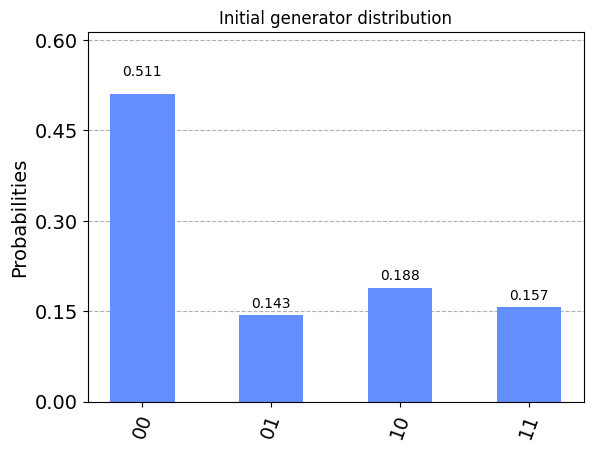

In [12]:
init_gen_circuit = generator.bind_parameters(init_gen_params)
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)

In [13]:
# Initialize Adam optimizer from Keras
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [14]:
# Initialize variables to track metrics while training
best_gen_params = tf.Variable(init_gen_params)
gloss = []
dloss = []
kl_div = []

In [15]:
TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. |"
print(TABLE_HEADERS)
for epoch in range(100):
    #--- Quantum discriminator parameter updates ---#
    D_STEPS = 5 # N discriminator updates per generator update
    for disc_train_step in range(D_STEPS):
        # Partial derivatives wrt θ_D
        d_fake = disc_fake_qnn.backward(gen_params, disc_params
                                       )[1].todense()[0, 0b100:]
        d_fake = np.sum(d_fake, axis=0)
        d_real = disc_real_qnn.backward([], disc_params
                                       )[1].todense()[0, 0b100:]
        d_real = np.sum(d_real, axis=0)
        # Recall Cost_D structure
        grad_dcost = [d_fake[i] - d_real[i] for i in range(N_DPARAMS)]
        grad_dcost = tf.convert_to_tensor(grad_dcost)
        # Update disc params with gradient
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                    [disc_params]))
        # Track discriminator loss
        if disc_train_step % D_STEPS == 0:
            dloss.append(discriminator_cost(disc_params))

    #--- Quantum generator parameter updates ---#
    for gen_train_step in range(1):
        # Compute partial derivatives of prob(fake|true) wrt each
        # generator weight
        grads = gen_qnn.backward(disc_params, gen_params)
        grads = grads[1].todense()[0][0b100:]
        # Recall Cost_G structure and the linearity of
        # the derivative operation
        grads = -np.sum(grads, axis=0)
        grads = tf.convert_to_tensor(grads)
        # Update gen params with gradient
        generator_optimizer.apply_gradients(zip([grads], [gen_params]))
        gloss.append(generator_cost(gen_params))

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.bind_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    if np.min(kl_div) == current_kl:
        # New best
        # serialize & deserialize to simply ensure zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 10 == 0:
        # print table every 10 epochs
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1], kl_div[-1])):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

Epoch | Generator cost | Discriminator cost | KL Div. |
    0 |         -0.331 |            -0.0511 |    0.57 |
   10 |          -0.22 |             -0.789 |    0.77 |
   20 |         -0.474 |             -0.511 |   0.801 |
   30 |         -0.739 |              -0.22 |   0.392 |
   40 |         -0.704 |             -0.165 |   0.202 |
   50 |         -0.576 |            -0.0454 |   0.119 |
   60 |         -0.754 |            -0.0784 |   0.181 |
   70 |          -0.41 |             -0.334 |   0.182 |
   80 |         -0.644 |             -0.142 |  0.0756 |
   90 |         -0.569 |             -0.155 |  0.0966 |


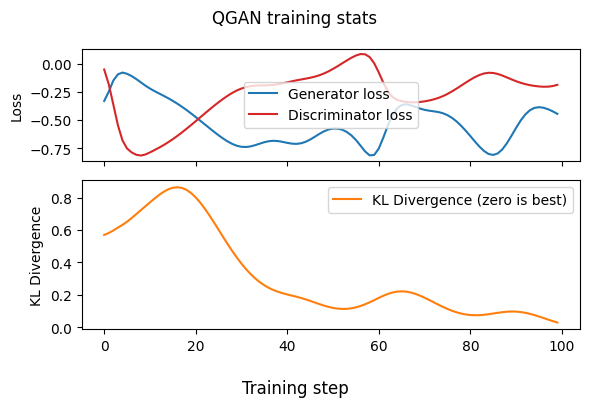

In [16]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();

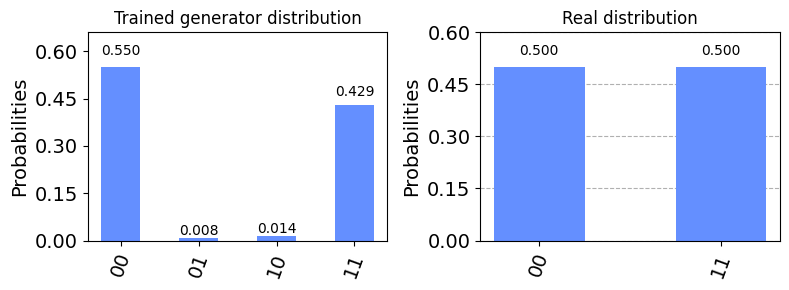

In [17]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.bind_parameters(
    best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax=ax2)
ax2.set_title("Real distribution")
fig.tight_layout()